<a href="https://colab.research.google.com/github/tathi-martins/Alura-Bootcamp-Ciencia-de-Dados-Aplicada-2/blob/add-license-1/Super_Projeto_modulo03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Início - Conhecendo os dados e Objetivo:**

# **Objetivo:**

 Objetivo principal é fazer uma projeção de casos de COVID-19 para os próximos 15 dias na cidade de Araraquara. Com isso, esperamos ajudar o poder público e sua gestão na tomada de decisões no combate à COVID-19.

 **As etapas do processo:**

- 1.0 - Conhecendo o conjunto de dados;
- 2.0 - Fazendo uma breve análise exploratória;
- 3.0 - Treinando e testando os modelos;
- 4.0 - Conclusão.

# **1.0 - Conhecendo o conjunto de dados**

Vamos usar o banco de dados do estado de São Paulo com informações atualizadas sobre a COVID-19, no site do [SEADE](https://www.seade.gov.br/coronavirus/) e do [SIMI](https://www.saopaulo.sp.gov.br/planosp/simi/dados-abertos/) de São Paulo.

Os dados são atualizados diáriamente e estou usando dados que vão do início dos casos em São Paulo em março de 2020 até 27 de junho de 2021.

**Dicionário de Dados**

- nome_munic: Nome do município

- codigo_ibge: Código do município no IBGE (7 dígitos)

- datahora: Data no formato YYYY-MM-DD

- casos: Casos totais registrados até a data

- casos_novos: Casos novos registrados na data

- casos_pc: Casos totais por 100 mil habitantes

- casos_mm7d: Média móvel dos últimos 7 dias dos novos casos

- obitos: Óbitos totais registrados até a data

- obitos_novos: Óbitos novos registrados na data

- obitos_pc: Óbitos totais por 100 mil habitantes

- obitos_mm7d: Média móvel dos últimos 7 dias dos novos óbitos

- letalidade: casos / obitos

[Fonte](https://www.saopaulo.sp.gov.br/wp-content/uploads/2020/08/Dic.-dados_dados_covid_municipios_sp.pdf): Secretaria de Estado da Saúde (e-SUS, SIVEP-Gripe, RedCap).

Nota: Para visualizar o dicionário completo clique no link acima.

**Quais serão as colunas utilizadas para as previsões?** datahora e casos_novos.

# **Importando as Bibliotecas e o dataframe**

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly.graph_objects as go
from sklearn.preprocessing import QuantileTransformer
from fbprophet import Prophet # fbprophet é só para o Google Colab, se usar outra IDE, é só tirar o fbprophet e importar como Prophet apenas.
from fbprophet.plot import add_changepoints_to_plot
from pandas.plotting import autocorrelation_plot
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_tweedie_deviance
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [ ]:
# Link dos dados
url = 'https://github.com/tathi-martins/Alura-Bootcamp-Ciencia-de-Dados-Aplicada-2/raw/main/Modulo03/20210627_dados_covid_municipios_sp.zip'
url2 = 'https://github.com/tathi-martins/Alura-Bootcamp-Ciencia-de-Dados-Aplicada-2/raw/main/Modulo03/00415366-122a-41ce-8aa5-f81c819c9c5e.xlsx'
url3 = 'https://github.com/tathi-martins/Alura-Bootcamp-Ciencia-de-Dados-Aplicada-2/raw/main/Modulo03/faba911e-e4b1-4264-9f21-e513b7624e3e.xlsx'

In [ ]:
dados = pd.read_csv(url, sep=';')
dados_vacinacao = pd.read_excel(url2)
dados_vacinacao2 = pd.read_excel(url3)

In [ ]:
dados.head()

,nome_munic,codigo_ibge,dia,mes,datahora,casos,casos_novos,casos_pc,casos_mm7d,obitos,obitos_novos,obitos_pc,obitos_mm7d,letalidade,nome_ra,cod_ra,nome_drs,cod_drs,pop,pop_60,area,map_leg,map_leg_s,latitude,longitude,semana_epidem
0,Adamantina,3500105,25,2,25/02/2020,0,0,0,0,0,0,0,0,0,RA de Presidente Prudente,9,Marília,5,33894,7398,41199,0.0,8.0,"-21,682","-51,0737",9
1,Adolfo,3500204,25,2,25/02/2020,0,0,0,0,0,0,0,0,0,RA de São José do Rio Preto,14,São José do Rio Preto,15,3447,761,21106,0.0,8.0,"-21,2325","-49,6451",9
2,Aguaí,3500303,25,2,25/02/2020,0,0,0,0,0,0,0,0,0,RA de Campinas,4,São João da Boa Vista,14,35608,5245,47455,0.0,8.0,"-22,0572","-46,9735",9
3,Águas da Prata,3500402,25,2,25/02/2020,0,0,0,0,0,0,0,0,0,RA de Campinas,4,São João da Boa Vista,14,7797,1729,14267,0.0,8.0,"-21,9319","-46,7176",9
4,Águas de Lindóia,3500501,25,2,25/02/2020,0,0,0,0,0,0,0,0,0,RA de Campinas,4,Campinas,3,18374,3275,6013,0.0,8.0,"-22,4733","-46,6314",9


**Preparando os dados**

In [ ]:
labels = ['Município',	'Cód. IBGE',	'UF',	'Região']
df_vacinacao = dados_vacinacao2.drop(columns=labels).copy()
df_vacinacao.set_index('Fabricante', inplace=True)
df_vacinacao

,Doses Aplicadas,Dose 1,Dose 2
Fabricante,,,
BUTANTAN/SINOVAC,62464,33562,28902
FIOCRUZ/ASTRAZENECA,56607,51428,5179
PFIZER/BIONTECH,4661,4651,10


In [ ]:
# Converte os dados da coluna datahora em um formato que pode ser convertido em datetime
dados['datahora'] = pd.to_datetime(dados['datahora'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

# Converte os dados da coluna datahora em datetime
dados['datahora'] = pd.to_datetime(dados['datahora'], format='%Y-%m-%d')

In [ ]:
# Criando o dataframe de Araraquara:
dados_araraquara = dados[(dados['nome_munic']=='Araraquara')].copy()

In [ ]:
# Copiando o dataframe para poder tratar os outliers
dados_araraquara2 = dados_araraquara.copy()

In [ ]:
# Aplicando método de pre-processamento dos dados do scikit-learn, o QuantileTransformer
dados_araraquara2[['casos_novos', 'obitos_novos']] = QuantileTransformer().fit_transform(dados_araraquara2[['casos_novos', 'obitos_novos']])

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2357: UserWarning:

n_quantiles (1000) is greater than the total number of samples (489). n_quantiles is set to n_samples.



# **2.0 - Fazendo uma breve análise exploratória**

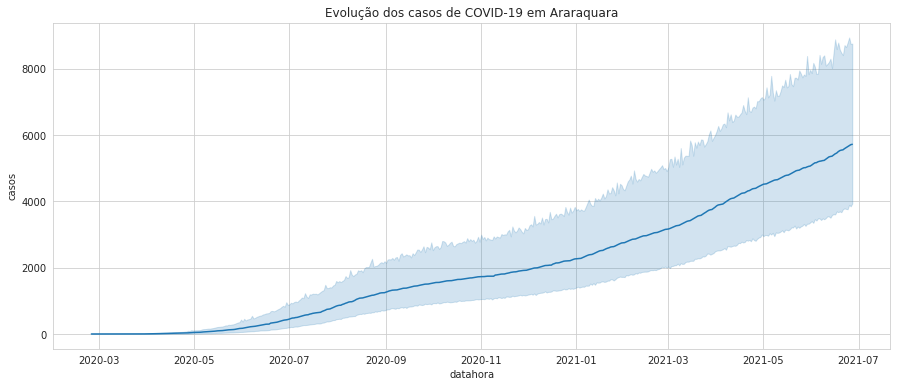

In [ ]:
# Criando o gráfico de dados
plt.figure(figsize=(15,6))
sns.set_style('whitegrid')
sns.lineplot(data=dados, x='datahora', y='casos').set_title('Evolução dos casos de COVID-19 em Araraquara')
plt.show()

O gráfico mostra o que parece ser um crescimento exponencial de casos de COVID-19 no estado de São Paulo.

**Criando um gráfico para analisarmos o crescimento logaritmo dos casos na cidade de Araraquara**

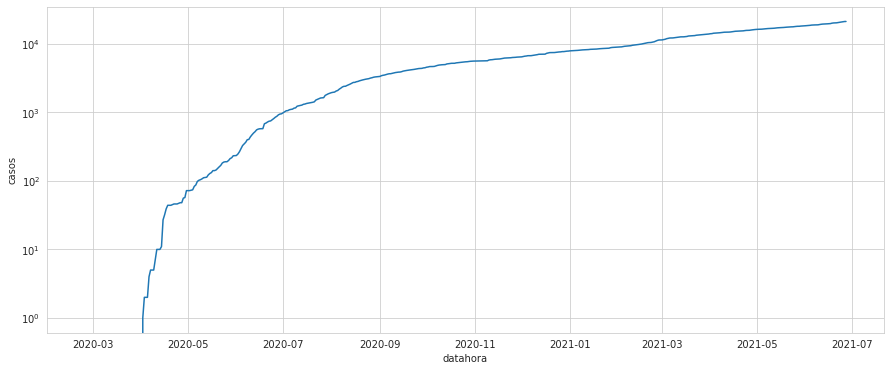

In [ ]:
plt.figure(figsize=(15,6))
sns.lineplot(data=dados_araraquara, x='datahora', y='casos')
mpl.pyplot.yscale('log')

Podemos confirmar que há um crescimento exponencial de casos na cidade de Araraquara, apesar de observarmos pequenas variações, provavelmente devidas às restrições de convívio social, com fechamento do comercio entre outras atividades econômicas e do distanciamento social mais rigoroso que varia muito a cada mês.

**Agora vamos verificar se há uma forte sazonalidade nos casos notificados**

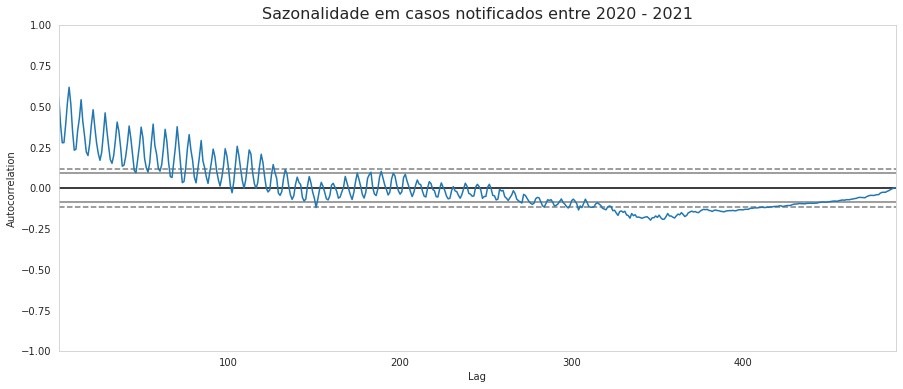

In [ ]:
# Configurando o tamanho do gráfico
plt.figure(figsize=(15,6))
{}
autocorrelation_plot(dados_araraquara['casos_novos'])

# Título do gráfico
plt.title('Sazonalidade em casos notificados entre 2020 - 2021', fontsize=16)

plt.show()

O gráfico acima nos mostra que há uma forte sazonalidade nas notificações de casos de COVID-19 bem no início da série temporal, porque podemos notar que a linha azul está fora da linha pontilhada e os números estão bem acima de zero, o que indica que há uma correlação temporal, uma sazonalidade nas notificações dos casos de COVID-19.

Porém, isso mudou à medida que o tempo foi passando e a pandemia foi evoluindo, hoje vemos que há um novo padrão nas notificações e com isso a sazonalidade também foi alterada.

**Vamos verificar a sazonalidade do ano de 2021 apenas**

In [ ]:
# Criando uma nova coluna chamada 'ano' para armazenar o ano separado das outras datas
dados_araraquara['ano'] = pd.DatetimeIndex(dados_araraquara['datahora']).year

# Criando um novo dataframe com apenas os dados de 2021
dados_arara_2021 = dados_araraquara.query('ano == 2021')

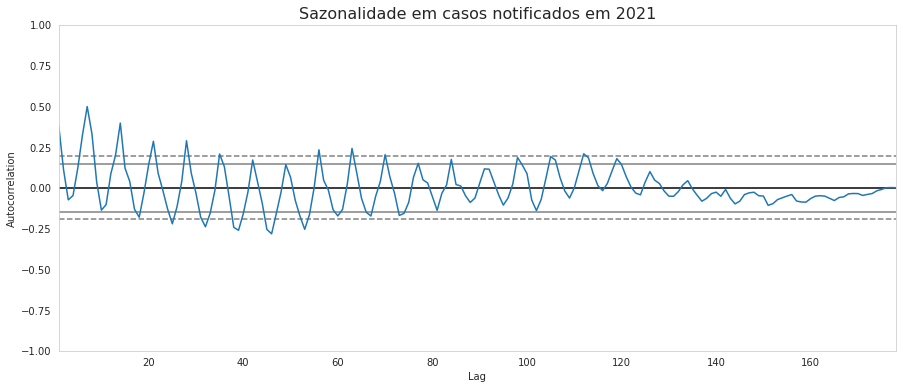

In [ ]:
# Configurando o tamanho do gráfico
plt.figure(figsize=(15,6))
{}
autocorrelation_plot(dados_arara_2021['casos_novos'])

# Título do gráfico
plt.title('Sazonalidade em casos notificados em 2021', fontsize=16)

plt.show()

A correlação em 2021 é bem mais fraca do que quando observamos no panorama geral da pandemia, porém o padrão é semelhante, começa mais forte e termina mais fraca.

O que podemos inferir disto? Uma possível explicação para isso seria uma constante mudança no comportamento da pandemia do COVID-19 na cidade, com mais mudanças no padrão de contaminação e de medidas de restrição.

**Vamos calcular a média móvel de casos e de óbitos:**

In [ ]:
dados_araraquara['media_movel_casos'] = dados_araraquara['casos_novos'].rolling(window=7, center=False).mean() # Média móvel dos últimos 7 dias
dados_araraquara['media_movel_obitos'] = dados_araraquara['obitos_novos'].rolling(window=7, center=False).mean()

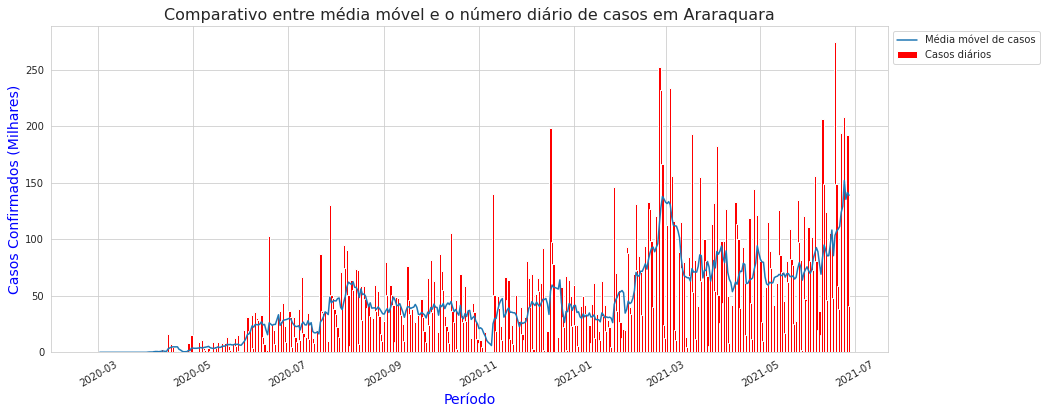

In [ ]:
# Configurando o tamanho do gráfico
plt.figure(figsize=(15,6))

plt.bar(dados_araraquara['datahora'], dados_araraquara['casos_novos'], width=1.5, color='red')
sns.lineplot(data=dados_araraquara, x='datahora', y='media_movel_casos')

# Título do gráfico
plt.title('Comparativo entre média móvel e o número diário de casos em Araraquara', fontsize=16)

# Configurando as labels
plt.xlabel('Período', fontsize=14, color='b')
plt.ylabel('Casos Confirmados (Milhares)', fontsize=14, color='b')

# Configurando as legendas
plt.legend(labels=['Média móvel de casos', 'Casos diários'], loc = 2, bbox_to_anchor = (1, 1))

# Configurando o eixo x
plt.xticks(rotation=30)

plt.show()

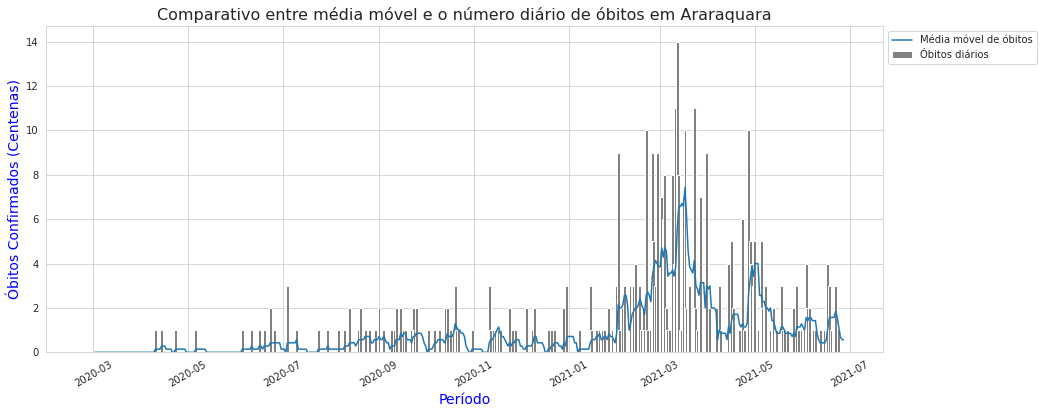

In [ ]:
# Configurando o tamanho do gráfico
plt.figure(figsize=(15,6))

# criando o gráfico de óbitos diários
plt.bar(dados_araraquara['datahora'], dados_araraquara['obitos_novos'], width=1.9, color='grey')

# Criando o gráfico com a média móvel de óbitos
sns.lineplot(data=dados_araraquara, x='datahora', y='media_movel_obitos')

# Título do gráfico
plt.title('Comparativo entre média móvel e o número diário de óbitos em Araraquara', fontsize=16)

# Configurando as labels
plt.xlabel('Período', fontsize=14, color='b')
plt.ylabel('Óbitos Confirmados (Centenas)', fontsize=14, color='b')

# Configurando as legendas
plt.legend(labels=['Média móvel de óbitos', 'Óbitos diários'], loc = 2, bbox_to_anchor = (1, 1))

# Configurando o eixo x
plt.xticks(rotation=30)

plt.show()

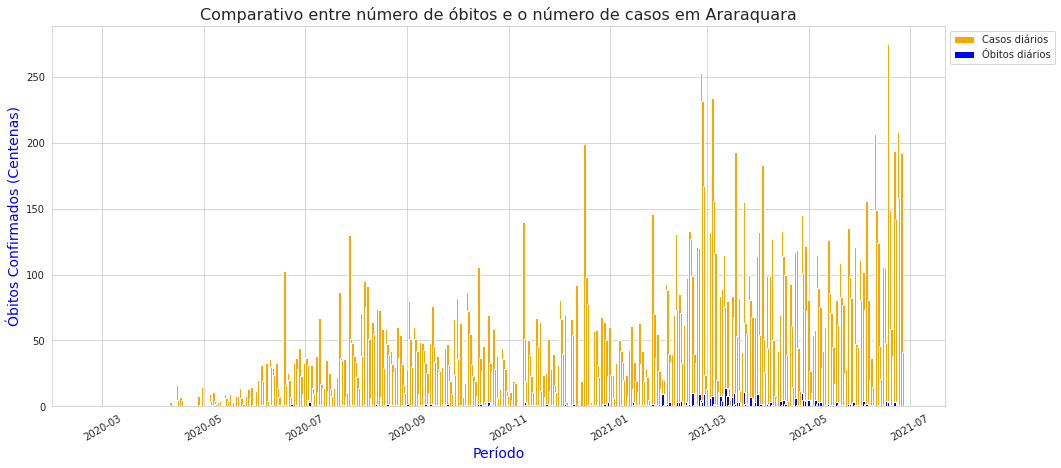

In [ ]:
# Configurando o tamanho do gráfico
plt.figure(figsize=(16,7))

# criando o gráfico de casos diários
plt.bar(dados_araraquara['datahora'], dados_araraquara['casos_novos'], width=1.6, color='orange')
plt.bar(dados_araraquara['datahora'], dados_araraquara['obitos_novos'], width=1.6, color='blue')

# Criando o gráfico com a média móvel de óbitos
plt.bar(dados_araraquara['datahora'], dados_araraquara['obitos_novos'], width=1.6, color='blue')

# Título do gráfico
plt.title('Relação entre número de óbitos e o número de casos em Araraquara', fontsize=16)

# Configurando as labels
plt.xlabel('Período', fontsize=14, color='b')
plt.ylabel('Óbitos Confirmados (Centenas)', fontsize=14, color='b')

# Configurando as legendas
plt.legend(labels=['Casos diários', 'Óbitos diários'], loc = 2, bbox_to_anchor = (1, 1))

# Configurando o eixo x
plt.xticks(rotation=30)

plt.show()

Podemos observar que apesar do número de casos estar subindo, o número de mortes está diminuindo. Seria o efeito da vacinação?

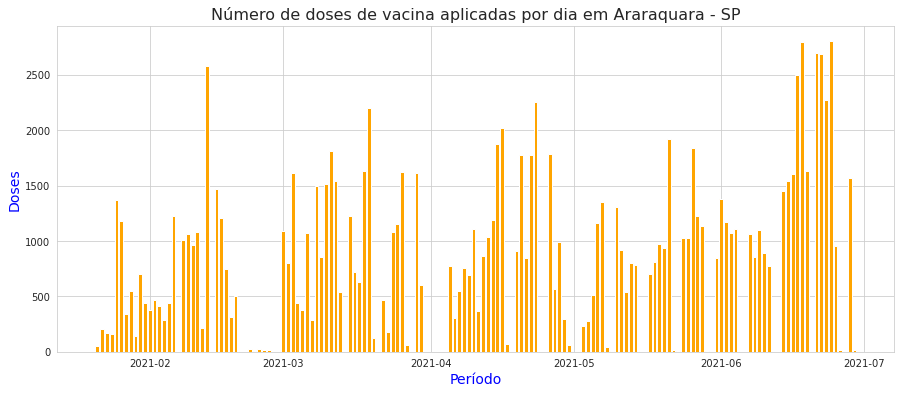

In [ ]:
# Configurando o tamanho do gráfico
plt.figure(figsize=(15,6))

# criando o gráfico de doses diárias de vacina
plt.bar(dados_vacinacao['Data Vacinação'], dados_vacinacao['quantidade'], width=0.8, color='orange')

# Título
plt.title('Número de doses de vacina aplicadas por dia em Araraquara - SP', fontsize=16)

# Configurando as labels
plt.xlabel('Período', fontsize=14, color='b')
plt.ylabel('Doses', fontsize=14, color='b')

plt.show()

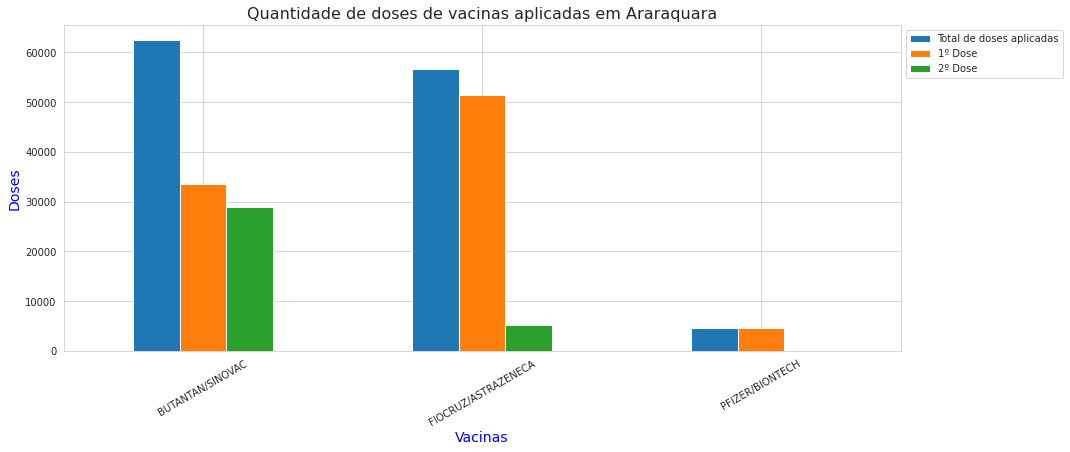

In [ ]:
# Gráfico
df_vacinacao.sort_values('Fabricante').plot(kind='bar', figsize=(15,6))

# Título do gráfico
plt.title('Quantidade de doses de vacinas aplicadas em Araraquara', fontsize=16)

# Legendas
plt.legend(labels=['Total de doses aplicadas', '1º Dose', '2º Dose'], loc = 2, bbox_to_anchor = (1, 1))

# Configurando as labels
plt.xlabel('Vacinas', fontsize=14, color='b')
plt.ylabel('Doses', fontsize=14, color='b')

# Configurando o eixo x
plt.xticks(rotation=30)

plt.show()

No total, em torno de 41% da população de Araraquara já foi vacinada com a primeira dose. No ranking dos municípios de São Paulo que mais vacinaram, Araraquara se encontra na 378º posição tanto no número absoluto de doses aplicadas, quanto no percentual de doses em relação à população. No total foram aplicadas 137 072 mil doses de vacinas contra a COVID-19 no município.

Fonte ([SIMI](https://www.saopaulo.sp.gov.br/planosp/simi/dados-abertos/))

# **3.0 - Treinando e testando os modelos**

Eu testei vários parâmetros e configurações diferentes para chegar ao melhor modelo. Usei dados de isolamento social e de estação do ano, como o inverno, mas não fizeram nenhum impacto positivo no modelo então as descartei. O modelo abaixo foi o mais ajustado, com melhores resultados de métricas de performance.

**Criando as listas com os feriados da cidade de Araraquara**

In [ ]:
# Feriados em Araraquara

feriados_2020 = [
'2020-02-25',
'2020-02-26',
'2020-04-10',
'2020-02-25',
'2020-02-26',
'2020-04-10',
'2020-04-21',
'2020-05-01',
'2020-05-20',
'2020-05-21', 
'2020-05-22',
'2020-05-25',
'2020-06-11',
'2020-08-22',
'2020-10-12',
'2020-11-02',
'2020-11-15',
'2020-11-20',
'2020-12-25'
]

feriados_2021 = [
'2021-01-01',
'2021-02-15',
'2021-02-16',
'2021-02-17',
'2021-03-26',
'2021-03-29',
'2021-03-30',
'2021-03-31',
'2021-04-01',
'2021-04-02',
'2021-04-21',
'2021-05-01',
'2021-06-03',
'2021-07-09',
'2021-08-22',
'2021-10-12',
'2021-11-02',
'2021-11-15',
'2021-11-20',
'2021-12-25'
]

feriados_2020 = pd.DataFrame({
  'holiday': 'feriados_2020',
  'ds': pd.to_datetime(feriados_2020)
})

feriados_2021 = pd.DataFrame({
  'holiday': 'feriados_2021',
  'ds': pd.to_datetime(feriados_2021)
})

feriados = pd.concat((feriados_2020, feriados_2021))

In [ ]:

# Criando o dataframe de treino
df = pd.DataFrame()

df['ds'] = dados_araraquara2['datahora'][:467]
df['y'] = dados_araraquara2['casos_novos'][:467]

# Criando o dataframe de teste
df_teste = pd.DataFrame()

df_teste['ds'] = dados_araraquara2['datahora'][467:]
df_teste['y'] = dados_araraquara2['casos_novos'][467:]

**Vamos rodar o nosso modelo pela primeira vez**

In [ ]:
modelo = Prophet(n_changepoints=25, changepoint_prior_scale=30.0, holidays=feriados, seasonality_mode='multiplicative', weekly_seasonality=7, interval_width=0.95)
modelo.fit(df)

dataframe_futuro = modelo.make_future_dataframe(periods=23)

previsao = modelo.predict(dataframe_futuro)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


**Uma medida importante para obter bons modelos de previsão é saber lidar com os outliers, no nosso caso vamos excluí-los.**

In [ ]:
# Primeiro para facilitar o trabalho, iremos remover o índice do df
novo_y = df.reset_index()
novo_y.tail(3)

,index,ds,y
464,299316,2021-06-03,0.895492
465,299961,2021-06-04,0.803279
466,300606,2021-06-05,0.971311


In [ ]:
# Retirando os outliers
sem_outliers = novo_y[(novo_y['y'] > previsao['yhat_lower'][:467]) 
& (novo_y['y'] < previsao['yhat_upper'][:467])]

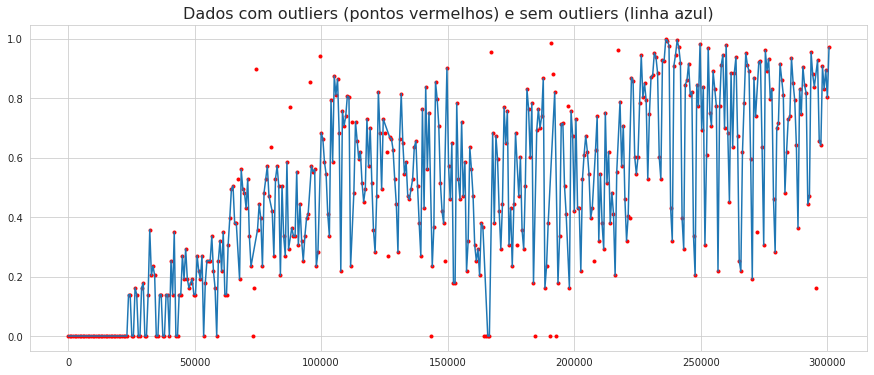

In [ ]:
# PLotando os dados de treino com outliers
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['y'], 'r.')

plt.title('Dados com outliers (pontos vermelhos) e sem outliers (linha azul)', fontsize=16)

# Plotando o gráfico de treino sem os outliers
plt.plot(sem_outliers['index'], sem_outliers['y'])

In [ ]:
# Dataset sem os outliers
df_sem_outliers = sem_outliers[['ds', 'y']]

In [ ]:
# Criando o modelo novo
modelo = Prophet(n_changepoints=25, changepoint_prior_scale=20.0, holidays=feriados, seasonality_mode='multiplicative', weekly_seasonality=7, interval_width=0.95)
modelo.fit(df_sem_outliers)

dataframe_futuro = modelo.make_future_dataframe(periods=23)

previsao = modelo.predict(dataframe_futuro)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


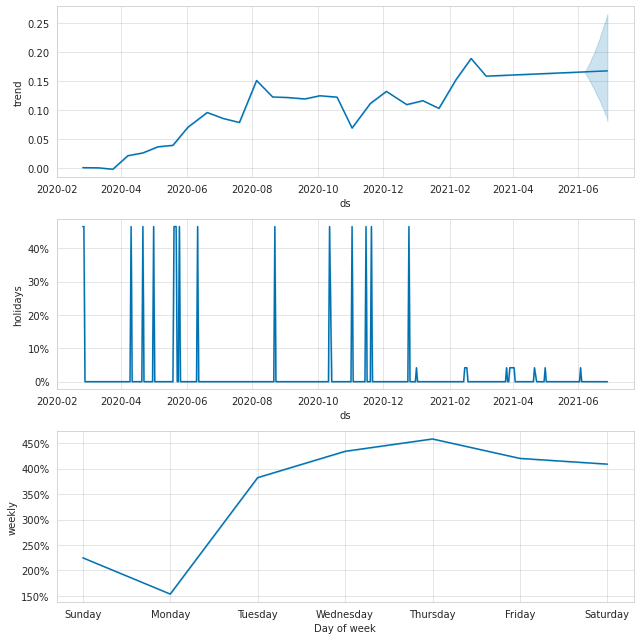

In [ ]:
modelo.plot_components(previsao);

O primeiro gráfico mostra a tendência geral de crescimento, que pode ser crescente ou decrescente, podemos ver o início de uma leve tendência de subida.

O segundo gráfico relata o comportamento ou o impacto dos feriados no nosso modelo. E no início da pandemia este impacto era bem maior do que o que vemos no mesmo período deste ano. Ainda não sabemos as razões para isso.

O terceiro gráfico mostra a sazonalidade semanal no número de casos, isso significa que temos mais notificações diárias de casos durante os dias úteis e com pico de notificações na quarta-feira.

**Gráfico da previsão com os changepoints**

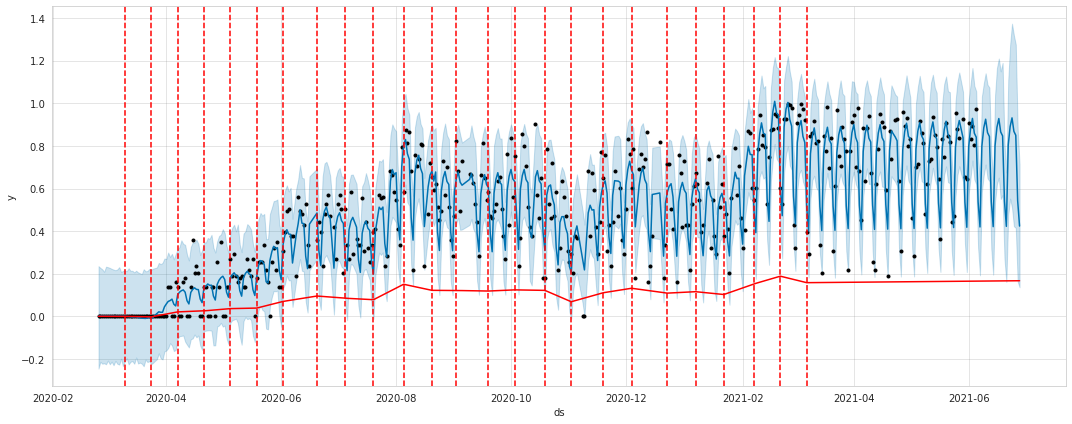

In [ ]:
# Colocando os changepoints
fig = modelo.plot(previsao, figsize=(15,6));
a = add_changepoints_to_plot(fig.gca(), modelo, previsao)

**Verificando se os feriados influenciaram nas previsões deste modelo**

In [ ]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df['ds'], y=df['y'], name='Dados reais',))
fig.add_trace(go.Scatter(x=previsao['ds'], y=previsao['yhat'], name='Predição',))
fig.add_trace(go.Scatter(x=previsao['ds'], y=previsao['holidays'], name='Feriados',))
fig.show()

Neste gráfico podemos averiguar que de fato os feriados tiveram uma influência nos casos reais e consequentemente tiveram impacto no modelo de previsão.

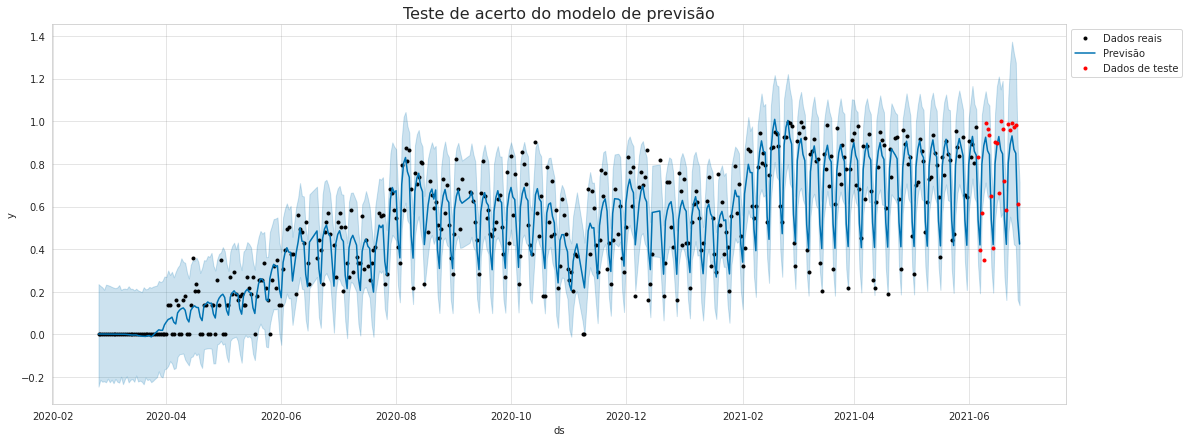

In [ ]:
fig = modelo.plot(previsao, figsize=(15,6));
plt.plot(df_teste['ds'], df_teste['y'], '.r')

plt.title('Teste de acerto do modelo de previsão', fontsize=16)

plt.legend(labels=['Dados reais', 'Previsão', 'Dados de teste'], loc = 2, bbox_to_anchor = (1, 1))

plt.show()

**Avaliando o nosso modelo**

O Prophet possui ferramentas de métrica de performance (RMSE, MSE, MAE, MAPE, MDAPE) e validação de performance (cross_validation) para que possamos avaliar se o nosso modelo está bem ajustado, se ele está performando bem.

Nós vamos usar algums destes métodos disponíveis aqui.

In [ ]:
df_cv = cross_validation(modelo, initial='180 days', period='15 days', horizon='15 days', parallel='processes')

INFO:fbprophet:Making 19 forecasts with cutoffs between 2020-08-24 00:00:00 and 2021-05-21 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f65463a5450>


In [ ]:
lista_cutoff = df_cv['cutoff'].unique()

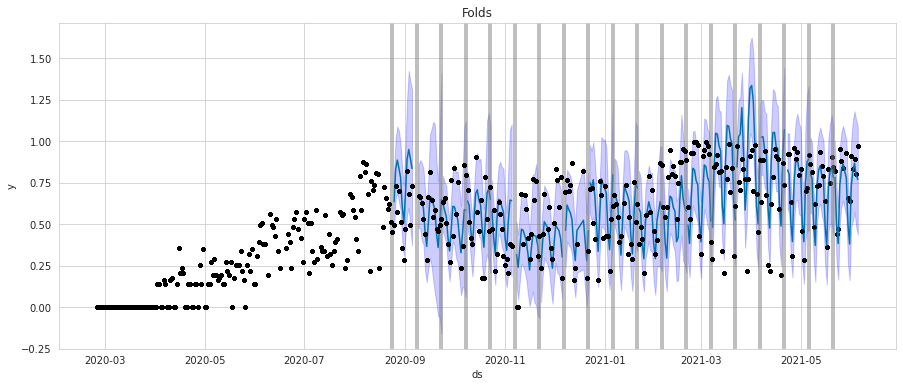

In [ ]:
plt.figure(figsize=(15,6))

for cutoff in lista_cutoff:

    df_cv_cut = df_cv[df_cv['cutoff'].values == cutoff]
   
    ax = plt.plot(modelo.history['ds'].values, modelo.history['y'], 'k.')

    plt.plot(df_cv_cut['ds'].values, df_cv_cut['yhat'], ls='-', c='#0072B2', label='previsão')
    
    plt.fill_between(df_cv_cut['ds'].values, df_cv_cut['yhat_lower'],
                    df_cv_cut['yhat_upper'], color='blue',
                    alpha=0.2, label='intervalo de confiança')
    
    plt.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5, label='cutoff')
    
plt.title(f'Folds')
plt.ylabel('y')
plt.xlabel('ds')
fig.tight_layout()
plt.show()

In [ ]:
df_performance = performance_metrics(df_cv)

INFO:fbprophet:Skipping MAPE because y close to 0


In [ ]:
df_performance

,horizon,mse,rmse,mae,mdape,coverage
0,2 days,0.018290,0.135242,0.104986,0.134206,0.878205
1,3 days,0.026719,0.163461,0.126813,0.172557,0.775304
2,4 days,0.032637,0.180658,0.152271,0.212859,0.683761
3,5 days,0.030306,0.174085,0.137603,0.195414,0.730769
4,6 days,0.033588,0.183270,0.158612,0.242275,0.726244
5,7 days,0.041875,0.204633,0.177752,0.252513,0.678733
6,8 days,0.036060,0.189895,0.160302,0.246642,0.756410
7,9 days,0.030432,0.174448,0.133554,0.156545,0.819838
8,10 days,0.042268,0.205592,0.164276,0.237192,0.717949
9,11 days,0.053780,0.231905,0.183396,0.182784,0.730769


In [ ]:
# Métricas do sktLearn
print(f'Mae: ', mean_absolute_error(df_sem_outliers['y'][:432], previsao['yhat'][:432]))
print(f'Mean Squared Error: ', mean_squared_error(df_sem_outliers['y'][:432], previsao['yhat'][:432]))
print(f'Explained Variance Score: ', explained_variance_score(df_sem_outliers['y'][:432], previsao['yhat'][:432]))
print(f'R2: ', r2_score(df_sem_outliers['y'][:432], previsao['yhat'][:432]))
print(f'Mean Tweedie Deviance (equivalente ao mean_squared_error): ', mean_tweedie_deviance(df_sem_outliers['y'][:432], previsao['yhat'][:432], power=0))

Mae:  0.08563014075337477
Mean Squared Error:  0.012146702569392155
Explained Variance Score:  0.856830122056735
R2:  0.856828250193937
Mean Tweedie Deviance (equivalente ao mean_squared_error) 0.012146702569392155


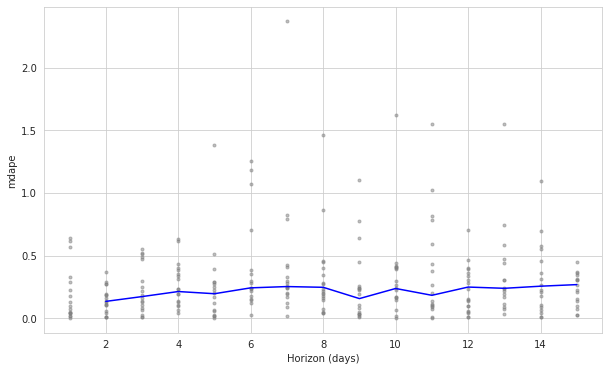

In [ ]:
plot_cross_validation_metric(df_cv, metric='mdape');

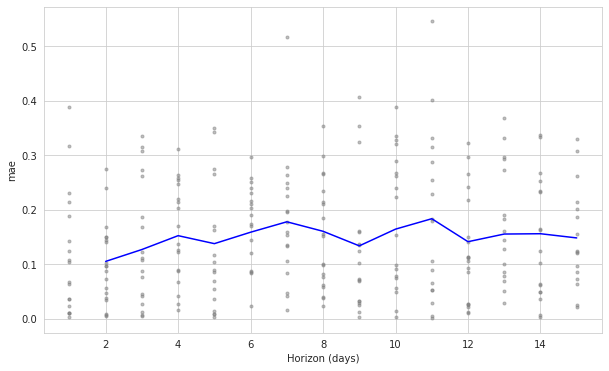

In [ ]:
plot_cross_validation_metric(df_cv, metric='mae');

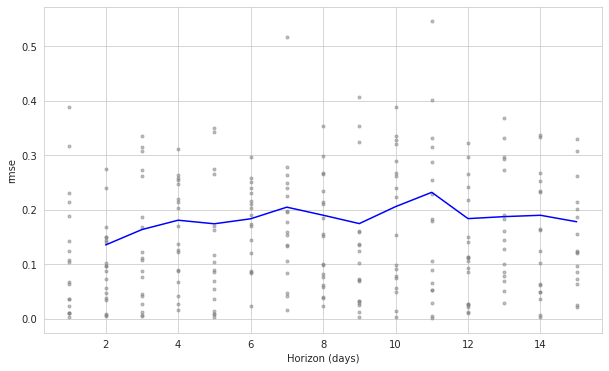

In [ ]:
plot_cross_validation_metric(df_cv, metric='rmse');

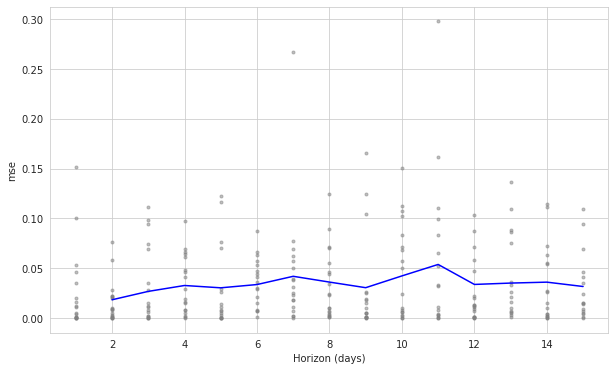

In [ ]:
plot_cross_validation_metric(df_cv, metric='mse');

# **4.0 - Conclusão**

O modelo de crescimento logístico é um modelo de regressão utilizado em modelos matemáticos de epidemiologia para estimar a taxa de crescimento e declínio de contágio. O modelo assume um crescimento exponencial no início da epidemia até atingir o pico, seguido por um aumento constante e finalmente terminando com uma taxa de crescimento decrescente. 

O crescimento logístico também é caracterizado pelo gráfico em S, e a pandemia da COVID-19 é formada por várias sucessões de S, isso fica bem evidente quando vemos o gráfico de toda a série temporal.

Não foi adicionado na modelagem as medidas de distanciamento social mais restritivas, os chamados lockdown e nem o avanço da vacinação na cidade. Os dados vão até 27 de junho de 2021, fazendo com que tenhamos um pouco mais de um ano de coleta de dados, o que não é muito para criar uma análise preditiva mais robusta. Mesmo assim, foi possível criar modelos de previsão que apesar de algumas limitações, estarem bem ajustados e com métricas dentro de padrões aceitáveis.

Estimativas como esta realizadas neste projeto, tem como objetivo ajudar na tomada de decisões de gerentes em todas as áreas de atuação econômica e até mesmo da gestão pública. No nosso caso específico, no combate à COVID-19.

Usando modelos preditivos de machine learning poderíamos prever aumentos de casos e prever quando ocorreriam as próximas ondas de COVID-19, evitando que falte insumos importantes no combate à doença como oxigênio, remédios para intubação, entre outros, e também quando aumentar as restrições de convívio social. Sendo possível aplicar em outras áreas da gestão pública, evitando assim, desperdícios e má empregabilidade de recursos públicos.